my understanding is that i can take the boxes output and compare with the boxes values given by the data.<br>
Final report says IOU not good enough, need to know if the symbol is detected correctly so that means we'll need to get the word from the back and compare to the topic we detected and see how similar they are? WordEmbedModel??

I think the evaluation can just do with the IOU first at least for the week 8 meeting.
Ms Sailaja said we shld do precision, recall, and accuracy
precision = true positive/ all positive predictions
recall = true positive/ actual positive
accuracy is accuracy

but they have coco_eval and evaluate??? - ask abt this ig

Seniors Suggested
- add SentenceEmbreddeinModel to be able to handle Q&A + Slogans
- k-clustering for labels (they have a file /preprocess/clustered_symbol_lists)

In [1]:
from fasterrcnn_train import create_train_test_dataset
from dataset import AdsDataset
from detect import detect, draw_text
from preprocess.boxes import load_symbols_annotation
from preprocess.descriptors import load_annotation_json, SentimentPreProcessor
import cv2
import numpy as np
import pandas as pd

In [2]:
ads_dataset = AdsDataset()
train, test = create_train_test_dataset(ads_dataset)

In [3]:
#%% first 10 files for testing the function
files = test.dataset.image_path[:10]

In [4]:
# %% get the annotations for said files.
def testing(files):
   data = load_symbols_annotation() #loads the symbols.json file
   phrases = load_annotation_json() #loads the sentiments.json file
   prep = SentimentPreProcessor() #loads a dictionary for indexing phrase
   #get phrase, truth, and predicted bbox for each file
   for file in files:
      phrase_id = int(phrases[file][0][0])
      phrase = prep.id_to_word[phrase_id]
      filepath = "data/" + file
      preds = detect([filepath],  phrase, "sentiments", "0", True)
      print(preds)
      #function to compare coords for IOU intersection/matching

In [5]:
testing([files[2]])

data/annotations/Sentiments.json
TEST PREDICTIONS COMPLETE
[[71, 221, 249, 327, 'violence'], [61, 78, 235, 337, 'violence'], [54, 78, 246, 339, 'sex'], [100, 171, 220, 345, 'violence'], [101, 250, 207, 343, 'violence'], [2, 19, 308, 353, 'sex'], [66, 47, 212, 192, 'violence'], [31, 35, 248, 254, 'violence']]


In [6]:
#get the third file from Symbol.json
data = load_symbols_annotation()
data[files[2]]

[[317.0, 479.0, 6.0, 168.0, 'Promiscuity '],
 [93.0, 355.0, 230.0, 474.0, 'sexual promiscuity '],
 [80.0, 335.0, 240.0, 479.0, 'well traveled'],
 [106.0, 347.0, 228.0, 491.0, 'use condoms']]

In [7]:
bbox1 = [[71, 221, 249, 327, 'violence'], 
 [61, 78, 235, 337, 'violence'], 
 [54, 78, 246, 339, 'sex'], 
 [100, 171, 220, 345, 'violence'], 
 [101, 250, 207, 343, 'violence'], 
 [2, 19, 308, 353, 'sex'], 
 [66, 47, 212, 192, 'violence'], 
 [31, 35, 248, 254, 'violence']]
bbox2 = [[317.0, 479.0, 6.0, 168.0, 'Promiscuity '],
 [93.0, 355.0, 230.0, 474.0, 'sexual promiscuity '],
 [80.0, 335.0, 240.0, 479.0, 'well traveled'],
 [106.0, 347.0, 228.0, 491.0, 'use condoms']]

In [8]:
#from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation#:~:text=You%27re%20calculating%20the%20area,%2F%20(union_area%20-%20intersection_area)%20.
#there are other methods i just picked this for now because it was the first one.
#more methods are available from the same link, below the main answer
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ---------

    Returns
    -------
    float
        in [0, 1]
    """
    try:
        assert bb1[0] <= bb1[2]
        assert bb1[1] <= bb1[3]
        assert bb2[0] <= bb2[2]
        assert bb2[1] <= bb2[3]
    except:
        return 0.0

    #topleftx, toplefty, bototmrightx, bottomrighty
    #x1,y1,x2,y2
    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box.
    # NOTE: We MUST ALWAYS add +1 to calculate area when working in
    # screen coordinates, since 0,0 is the top left pixel, and w-1,h-1
    # is the bottom right pixel. If we DON'T add +1, the result is wrong.
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0] + 1) * (bb1[3] - bb1[1] + 1)
    bb2_area = (bb2[2] - bb2[0] + 1) * (bb2[3] - bb2[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
#%%Get total iou, precision, recall
#https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

def get_total_iou(true, pred):
    df = pd.read_csv('predres.csv')
    df = pd.DataFrame(df)
    for t in true:
        predno = []
        ious = []
        corrects = []
        for p in pred:
            iou = get_iou(t,p)
            ious.append(iou)
            corrects.append(iou>=0.5)
        df2 = pd.DataFrame({
                    "iou": ious,
                    "correct?" : corrects})
        df = df.append(df2, ignore_index = True)
    #print(df)
    df.to_csv("predres.csv")

In [14]:
def draw_bboxes(true, pred):
    """
    true: truths from Symbols.json
    pred: predicted values from model
    """
    bg_img = np.zeros([512,512,3],dtype=np.uint8)
    bg_img.fill(255)

    for t in true:
        cv2.rectangle(
                bg_img,
                (int(t[0]), int(t[1])),
                (int(t[2]), int(t[3])),
                (0,255,0),
                2,)
        draw_text(
                        img=bg_img,
                        text=t[4],
                        pos=(int(t[0]), int(t[1])),
                        text_color_bg=(0,255,0),
                        text_color = (0,0,0)
                    )

    for p in pred:
        cv2.rectangle(
                    bg_img,
                    (int(p[0]), int(p[1])),
                    (int(p[2]), int(p[3])),
                    (255,0,0),
                    2,)
        draw_text(
                        img=bg_img,
                        text=p[4],
                        pos=(int(p[0]), int(p[1])),
                        text_color_bg=(255,0,0),
                        text_color = (0,0,0)
                    )
    
    return bg_img

In [11]:
#uncomment to do new stuff
#get_total_iou(bbox1, bbox2)
df = pd.read_csv("predres.csv", index_col=0)
print(df.head(10))

        iou  correct?
0  0.000000     False
1  0.000000     False
2  0.000000     False
3  0.000000     False
4  0.000000     False
5  0.000000     False
6  0.006844     False
7  0.000000     False
8  0.000000     False
9  0.000000     False


In [12]:
from matplotlib import pyplot as plt

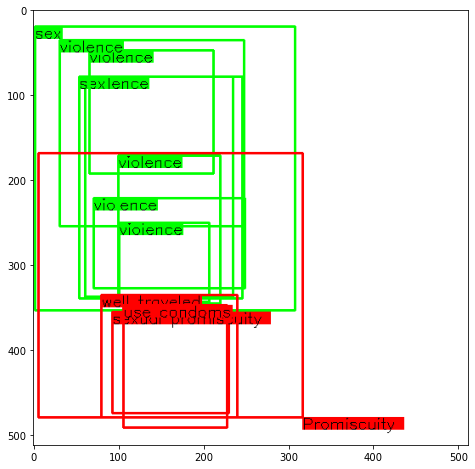

In [15]:
img = draw_bboxes(bbox1, bbox2)
plt.figure(figsize = (8,8))
plt.imshow(img)